In [ ]:
# default_exp subcoco_pl

# Exploring Object Detection using Pytorch Lightning Only

Instead of using higher level library such as IceVision, I am gonna try using what's in Torch Vision, see [example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

To force some learning, I shall attempt to port the example to [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as it removes a lot of boiler plate code and standardized Pytorch usage. It also makes advanced features like gradient accumulation and multi-GPU multi-node training simple.

In [ ]:
#export
import json, os, requests, sys, tarfile, torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.multiprocessing

from collections import defaultdict
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.core.step_result import TrainResult

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

from mcbbox.subcoco_utils import *

torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
#hide
from nbdev.showdoc import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}")
%load_ext autoreload
%autoreload 2
%matplotlib inline

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, pytorch_lightning 1.0.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

In [ ]:
train_json = fetch_subcoco(datadir='/tmp', url='http://files.fast.ai/data/examples/coco_tiny.tgz', img_subdir='train')

If using tiny Coco subset, use these values:
```
train_json = fetch_subcoco(url='http://files.fast.ai/data/examples/coco_tiny.tgz', img_subdir='train')
```

If using Sample Coco subset, use these values:
```
train_json = fetch_subcoco(url='https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', img_subdir='train_sample')
```

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 542959, 'file_name': '000000542959.jpg'},
 [{'image_id': 542959, 'bbox': [32.52, 86.34, 8.53, 9.41], 'category_id': 62},
  {'image_id': 542959, 'bbox': [98.12, 110.52, 1.95, 4.07], 'category_id': 86},
  {'image_id': 542959, 'bbox': [91.28, 51.62, 3.95, 5.72], 'category_id': 86},
  {'image_id': 542959,
   'bbox': [110.48, 110.82, 14.55, 15.22],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [96.63, 50.18, 18.67, 13.46],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [0.69, 111.73, 11.8, 13.06],
   'category_id': 62}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image...

In [ ]:
img_dir='/tmp/coco_tiny/train'
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
{ stats.cat2name[stats.lbl2cat[lid]]: len(ibs) for lid, ibs in stats.l2ibs.items()}

Categories 6, Images 200, Boxes 688, avg (w,h) (128.0, 128.0)avg cats/img 7.0, avg boxs/img 3.4, avg boxs/cat 114.7.
Image means by channel [126.2909314  109.02263367 100.61073242], std.dev by channel [65.60744282 65.09696176 60.4631069 ]


{'chair': 284, 'vase': 64, 'tv': 26, 'couch': 40, 'book': 254, 'remote': 20}

Print out number of boxes per category to see if the distribution is not too unbalanced...

Hmm, seems like a lot of chairs and books, but vases, tvs, couches and remotes are roughly 10x less. This may be a problem. 
But we have enough to test drive the training pipeline. To make it more balanced, may be I can combine vase+tv+couch+remote into a new category 'others' later?

## Look at Images

Let's look at an image annotation.

In [ ]:
img_pos = 127
img_id = train_json['images'][img_pos]['id']
l2bs = stats.img2l2bs[img_id]
img_fname = stats.img2fname[img_id]
img_id, img_fname, l2bs

(283316,
 '000000283316.jpg',
 {0: [],
  1: [],
  2: [],
  3: [(76.22, 14.96, 25.6, 17.26)],
  4: [],
  5: [(65.14, 13.53, 3.5, 6.95)],
  6: []})

## Overlay Boxes and Labels from Annotation

Let's overlay bounding boxes and labels over the image to confirm our understanding of the data.

Pick some random image to test drive the box overlay code...

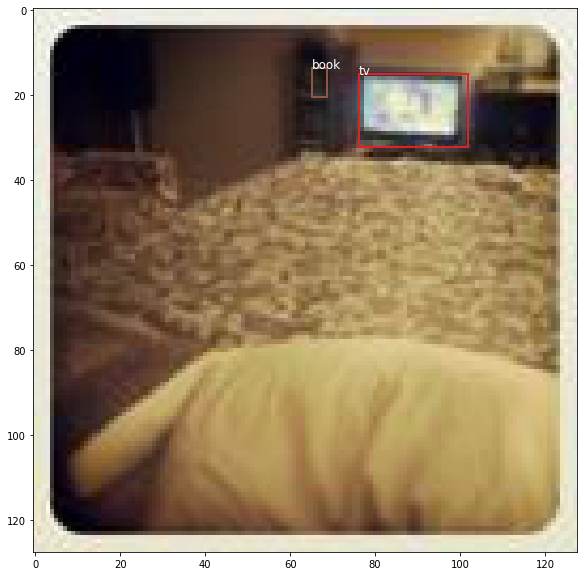

In [ ]:
img = Image.open(Path(img_dir)/stats.img2fname[img_id])
overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)

Looks good enough. Now wrap the Dataset into a DataModule...

In [ ]:
subcoco_dm = SubCocoDataModule(Path(img_dir), stats, resize=(128,128), bs=2, workers=1)
tdl=subcoco_dm.train_dataloader()
images, targets = next(iter(tdl))
len(images), len(targets)

(2, 2)

## Neural Network Architecture Model

On my Dell XPS15 GTX-1050 GPU w/ 4GB VRAM,  I can average 1 epoc every 120 min or so, at bs=2 acc=16, img 384x384, with unfrozen backbone.

Using my GCP w/ V100 of 16GB VRAM, I can fit bs=12 for sample_coco, acc=16, img 384x384, with unfrozen backbone, 1 epoc every ~25 minutes.

In [ ]:
#export
def run_training(stats:CocoDatasetStats, img_dir:str, img_sz=384, bs=12, acc=4, workers=4, head_runs=50, full_runs=200):
    
    frcnn_model = FRCNN(lbl2name=stats.lbl2name)

    print(f"Training with image size {img_sz}, auto learning rate, for {head_runs}+{full_runs} epochs.")
    chkpt_cb = ModelCheckpoint(
        filepath="models/FRCNN-subcoco-{epoch}-{val_acc:.2f}.ckpt",
        save_last=True,
        monitor='val_acc',
        mode='max',
        verbose=True,
    )
    
    # train head only, since using less params, double the bs and half the grad accumulation cycle to use more GPU VRAM
    if head_runs > 0:
        head_dm = SubCocoDataModule(img_dir, stats, resize=(img_sz,img_sz), bs=bs*2, workers=workers)
        trainer = Trainer(gpus=1, auto_lr_find=True, max_epochs=head_runs, checkpoint_callback=chkpt_cb, accumulate_grad_batches=max(1,int(acc//2)))
        trainer.fit(frcnn_model, head_dm)

    if full_runs > 0:
        frcnn_model.unfreeze() # allow finetuning of the backbone
        # finetune head and backbone
        full_dm = SubCocoDataModule(img_dir, stats, resize=(img_sz,img_sz), bs=bs, workers=workers)
        trainer = Trainer(gpus=1, auto_lr_find=True, max_epochs=full_runs, checkpoint_callback=chkpt_cb, accumulate_grad_batches=max(1,acc))
        trainer.fit(frcnn_model, full_dm)
    
    return frcnn_model

In [ ]:
if torch.cuda.is_available():
    frcnn_model = run_training(stats, img_dir, img_sz=128, bs=2, acc=2, workers=2, head_runs=1, full_runs=1)

GPU available: True, used: True
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


Training with image size 128, auto learning rate, for 1+1 epochs.


Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/brian/Projects/mcbbox/models/FRCNN-subcoco-epoch=0-val_acc=0.00.ckpt-v1.ckpt as top 1
Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/brian/Projects/mcbbox/models/FRCNN-subcoco-epoch=0-val_acc=0.00.ckpt-v1.ckpt as top 1
Saving latest checkpoint...
Saving latest checkpoint...


GPU available: True, used: True
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


Saving latest checkpoint...
Saving latest checkpoint...


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --host "0.0.0.0" 

Reusing TensorBoard on port 6006 (pid 22722), started 0:14:15 ago. (Use '!kill 22722' to kill it.)

## Inference

Time to see how well the model can perform.

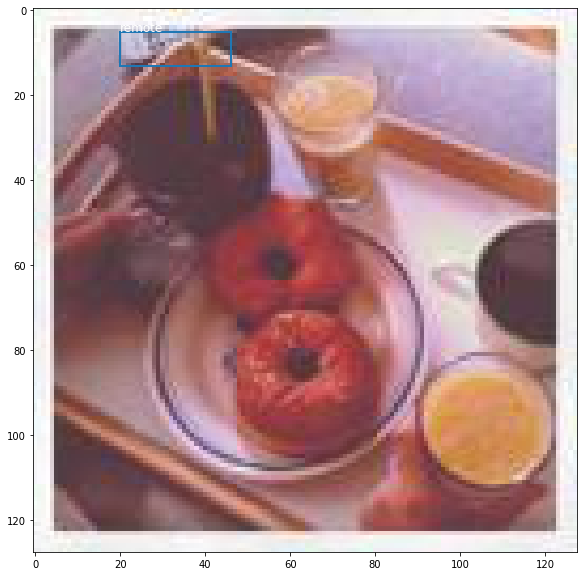

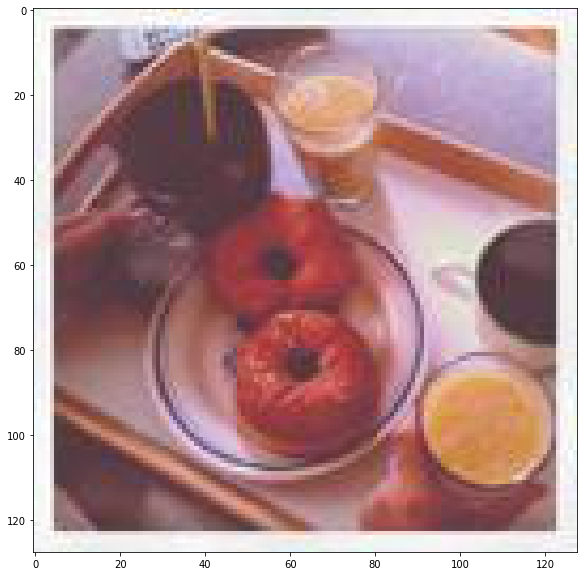

In [ ]:
# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    x = images[0]
    y = targets[0]
    pimg = torchvision.transforms.ToPILImage()(x)
    tgt_l2bs = defaultdict(empty_list)
    for l, b in zip(list(y['labels']), y['boxes']):
        tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

    overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

    frcnn_model.eval()
    pred = frcnn_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.5)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

Compare with Original Image before transformations incl. Normalization and Resize.

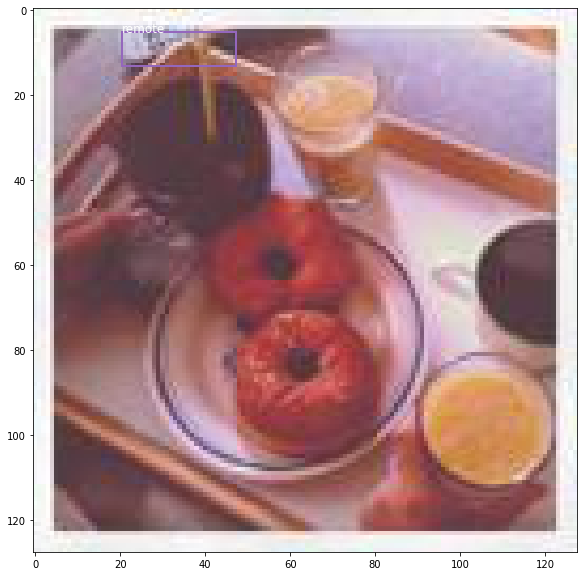

In [ ]:
img_id = int(y['image_id'])
img = Image.open(Path(img_dir)/stats.img2fname[img_id])
overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)

## Saving and Reloading using Underlying Pytorch (Lightning Saving still has bug)

In [ ]:
#export
def save_final(frcnn_model, model_save_path):
    torch.save(frcnn_model.model.state_dict(), model_save_path)

[autoreload of mcbbox.subcoco_utils failed: Traceback (most recent call last):
  File "/home/brian/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/brian/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/brian/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/brian/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/brian/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/brian/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: prepa

In [ ]:
model_save_path = f"models/FRCNN-subcoco-final.saved"
save_final(frcnn_model, model_save_path)
pretrained_model = FRCNN(lbl2name=stats.lbl2name)
pretrained_model.model.load_state_dict(torch.load(model_save_path))
pretrained_model.freeze()

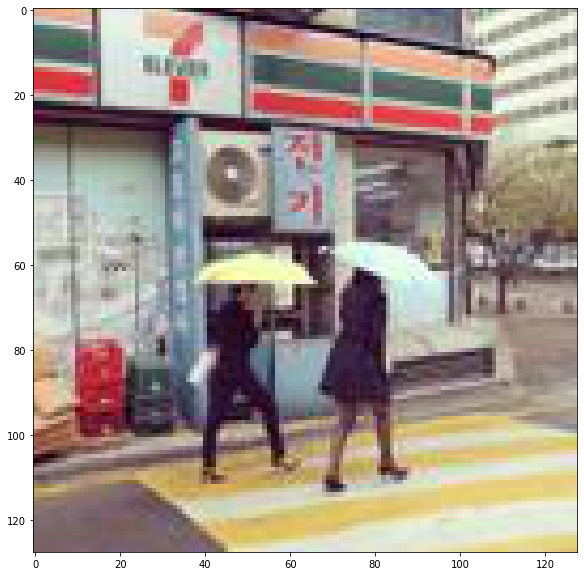

In [ ]:
# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    x = images[1]
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0])
    pimg = torchvision.transforms.ToPILImage()(x)

    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)